# Data Preprocessing

In [ ]:
import sqlite3
import pandas as pd
import numpy as np

# Step 1: Load Data from the SQLite database
def load_data_from_db(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Fetch all state-distance pairs
    cursor.execute("SELECT state, solution_length FROM puzzle_states")
    data = cursor.fetchall()

    # Close the connection
    conn.close()

    # Create a DataFrame from the fetched data
    df = pd.DataFrame(data, columns=['state', 'solution_length'])

    return df

# Step 2: Manhattan Distance Calculation
def calculate_manhattan_distance(state, goal_state):
    # Reshape the 1D flattened state back to a 3x3 grid
    state_reshaped = np.reshape(state, (3, 3))

    total_distance = 0
    for tile in range(1, 9):  # Ignore tile 0 (the blank space)
        x1, y1 = np.where(state_reshaped == tile)  # Current position
        x2, y2 = np.where(np.array(goal_state) == tile)  # Goal position
        total_distance += abs(x1[0] - x2[0]) + abs(y1[0] - y2[0])

    return total_distance

# Step 3: Misplaced Tiles Calculation
def calculate_misplaced_tiles(state, goal_state):
    state_reshaped = np.reshape(state, (3, 3))
    misplaced_count = 0
    for i in range(3):
        for j in range(3):
            if state_reshaped[i][j] != goal_state[i][j] and state_reshaped[i][j] != 0:
                misplaced_count += 1
    return misplaced_count

# Step 4: Tile Position Indicators Calculation
def calculate_tile_position_indicators(state, goal_state):
    state_reshaped = np.reshape(state, (3, 3))
    correct_row = 0
    correct_column = 0

    for i in range(3):
        for j in range(3):
            tile = state_reshaped[i][j]
            if tile != 0:
                goal_pos = np.where(np.array(goal_state) == tile)
                if i == goal_pos[0][0]:  # Correct row
                    correct_row += 1
                if j == goal_pos[1][0]:  # Correct column
                    correct_column += 1
    return correct_row, correct_column

# Step 5: Preprocess the data (add new features)
def preprocess_data_with_additional_features(df):
    goal_state = [[1, 2, 3], [4, 5, 6], [7, 8, 0]]  # Define the goal state

    df['flattened_state'] = df['state'].apply(lambda x: eval(x))  # Convert state string to list of lists

    # Flatten the state, calculate Manhattan distance, misplaced tiles, and tile position indicators
    df['flattened_state'] = df['flattened_state'].apply(lambda state: [tile for row in state for tile in row])
    df['manhattan_distance'] = df['flattened_state'].apply(lambda state: calculate_manhattan_distance(state, goal_state))
    df['misplaced_tiles'] = df['flattened_state'].apply(lambda state: calculate_misplaced_tiles(state, goal_state))
    df[['correct_row', 'correct_column']] = df['flattened_state'].apply(lambda state: pd.Series(calculate_tile_position_indicators(state, goal_state)))

    # Features include the flattened state and additional features
    X = pd.DataFrame(df['flattened_state'].tolist())
    X['manhattan_distance'] = df['manhattan_distance']
    X['misplaced_tiles'] = df['misplaced_tiles']
    X['correct_row'] = df['correct_row']
    X['correct_column'] = df['correct_column']

    y = df['solution_length']

    return X, y

# Step 6: Split the data into training and test sets
from sklearn.model_selection import train_test_split
def split_data(X, y, test_size=0.2):
    return train_test_split(X, y, test_size=test_size, random_state=42)

def main():
    # Make sure you've uploaded your SQLite database file in Colab
    db_path = '/content/puzzle_database.db'

    # Load data from the database
    df = load_data_from_db(db_path)

    # Preprocess data with additional features (Manhattan distance, misplaced tiles, tile indicators)
    X, y = preprocess_data_with_additional_features(df)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = split_data(X, y)

    # Now X_train, X_test, y_train, and y_test are ready with additional features for training models!
    print("Training data shape:", X_train.shape)
    print("Sample features (first row):", X_train.iloc[0])

if __name__ == "__main__":
    main()


Training data shape: (145152, 13)
Sample features (first row): 0                      3
1                      6
2                      7
3                      8
4                      2
5                      1
6                      5
7                      0
8                      4
manhattan_distance    19
misplaced_tiles        8
correct_row            1
correct_column         1
Name: 151157, dtype: int64


# Linear Regression

# Trained with linear regression with Manhattan distance

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Train a Linear Regression Model
def train_linear_regression(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

# Evaluate the Model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Calculate Mean Squared Error and Mean Absolute Error
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")

# Main function to load data, preprocess, train, and evaluate
def main():
    # Make sure you've uploaded your SQLite database file in Colab
    db_path = '/content/puzzle_database.db'

    # Load data from the database
    df = load_data_from_db(db_path)

    # Preprocess the data
    X, y = preprocess_data_with_additional_features(df)

    # Use only 'manhattan_distance' as the feature for training
    X_train, X_test, y_train, y_test = split_data(X[['manhattan_distance']], y)  # Selecting only the 'manhattan_distance'

    # Train Linear Regression
    linear_model = train_linear_regression(X_train, y_train)

    # Evaluate the Linear Regression model
    evaluate_model(linear_model, X_test, y_test)

if __name__ == "__main__":
    main()


Mean Squared Error (MSE): 7.779769029707702
Mean Absolute Error (MAE): 2.1957904558767747


# Trained with Linear Regression with Misplaced tiles

In [ ]:
def main():
    # Make sure you've uploaded your SQLite database file in Colab
    db_path = '/content/puzzle_database.db'

    # Load data from the database
    df = load_data_from_db(db_path)

    # Preprocess the data
    X, y = preprocess_data_with_additional_features(df)

    # Use only 'misplaced_tiles' as the feature for training
    X_train, X_test, y_train, y_test = split_data(X[['misplaced_tiles']], y)  # Selecting only 'misplaced_tiles'

    # Train Linear Regression
    linear_model = train_linear_regression(X_train, y_train)

    # Evaluate the Linear Regression model
    evaluate_model(linear_model, X_test, y_test)

if __name__ == "__main__":
    main()


Mean Squared Error (MSE): 10.649633705050777
Mean Absolute Error (MAE): 2.565648518123405


# Trained with Linear Regression with Correct Row

In [ ]:
def main():
    # Make sure you've uploaded your SQLite database file in Colab
    db_path = '/content/puzzle_database.db'

    # Load data from the database
    df = load_data_from_db(db_path)

    # Preprocess the data
    X, y = preprocess_data_with_additional_features(df)

    # Use only 'correct_row' as the feature for training
    X_train, X_test, y_train, y_test = split_data(X[['correct_row']], y)  # Selecting only 'correct_row'

    # Train Linear Regression
    linear_model = train_linear_regression(X_train, y_train)

    # Evaluate the Linear Regression model
    evaluate_model(linear_model, X_test, y_test)

if __name__ == "__main__":
    main()


Mean Squared Error (MSE): 10.601717775630764
Mean Absolute Error (MAE): 2.562155729621565


# Trained with Linear Regression with Correct Column

In [ ]:
def main():
    db_path = '/content/puzzle_database.db'

    # Load data from the database
    df = load_data_from_db(db_path)

    # Preprocess the data
    X, y = preprocess_data_with_additional_features(df)

    # Use only 'correct_column' as the feature for training
    X_train, X_test, y_train, y_test = split_data(X[['correct_column']], y)  # Selecting only 'correct_column'

    # Train Linear Regression
    linear_model = train_linear_regression(X_train, y_train)

    # Evaluate the Linear Regression model
    evaluate_model(linear_model, X_test, y_test)

if __name__ == "__main__":
    main()


Mean Squared Error (MSE): 10.618348021404307
Mean Absolute Error (MAE): 2.563074119876473


# Decision Tree Regressor

## Decision Tree Regressor with Manhattan distance

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Train a Decision Tree Regressor
def train_decision_tree(X_train, y_train):
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)
    return model

# Evaluate the Model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Calculate Mean Squared Error and Mean Absolute Error
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")

# Main function to load data, preprocess, train, and evaluate
def main():
    # Make sure you've uploaded your SQLite database file in Colab
    db_path = '/content/puzzle_database.db'

    # Load data from the database
    df = load_data_from_db(db_path)

    # Preprocess the data
    X, y = preprocess_data_with_additional_features(df)

    # Use only 'manhattan_distance' as the feature for training
    X_train, X_test, y_train, y_test = split_data(X[['manhattan_distance']], y)  # Selecting only 'manhattan_distance'

    # Train Decision Tree Regressor
    dt_model = train_decision_tree(X_train, y_train)

    # Evaluate the Decision Tree model
    evaluate_model(dt_model, X_test, y_test)

if __name__ == "__main__":
    main()


Mean Squared Error (MSE): 7.668757570749066
Mean Absolute Error (MAE): 2.1954475963594


## Decision Tree Regressor with Misplaced tiles

In [ ]:
def main():
    db_path = '/content/puzzle_database.db'

    # Load data from the database
    df = load_data_from_db(db_path)

    # Preprocess the data
    X, y = preprocess_data_with_additional_features(df)

    # Use only 'misplaced_tiles' as the feature for training
    X_train, X_test, y_train, y_test = split_data(X[['misplaced_tiles']], y)  # Selecting only 'misplaced_tiles'

    # Train Decision Tree Regressor
    dt_model = train_decision_tree(X_train, y_train)

    # Evaluate the Decision Tree model
    evaluate_model(dt_model, X_test, y_test)

if __name__ == "__main__":
    main()


Mean Squared Error (MSE): 10.605130957967193
Mean Absolute Error (MAE): 2.5632789455633187


# Decision Tree Regressor with Correct Row

In [ ]:
def main():
    db_path = '/content/puzzle_database.db'

    # Load data from the database
    df = load_data_from_db(db_path)

    # Preprocess the data
    X, y = preprocess_data_with_additional_features(df)

    # Use only 'correct_row' as the feature for training
    X_train, X_test, y_train, y_test = split_data(X[['correct_row']], y)  # Selecting only 'correct_row'

    # Train Decision Tree Regressor
    dt_model = train_decision_tree(X_train, y_train)

    # Evaluate the Decision Tree model
    evaluate_model(dt_model, X_test, y_test)

if __name__ == "__main__":
    main()


Mean Squared Error (MSE): 10.600346479057341
Mean Absolute Error (MAE): 2.5623941681434097


# Decision Tree Regressor with Correct Column

In [ ]:
def main():
    db_path = '/content/puzzle_database.db'

    # Load data from the database
    df = load_data_from_db(db_path)

    # Preprocess the data
    X, y = preprocess_data_with_additional_features(df)

    # Use only 'correct_column' as the feature for training
    X_train, X_test, y_train, y_test = split_data(X[['correct_column']], y)  # Selecting only 'correct_column'

    # Train Decision Tree Regressor
    dt_model = train_decision_tree(X_train, y_train)

    # Evaluate the Decision Tree model
    evaluate_model(dt_model, X_test, y_test)

if __name__ == "__main__":
    main()


Mean Squared Error (MSE): 10.61023082283117
Mean Absolute Error (MAE): 2.562381009028262


# Random Forest

# Trained with Random Forest with Manhattan distance

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Train a Random Forest Regressor
def train_random_forest(X_train, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

# Evaluate the Model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Calculate Mean Squared Error and Mean Absolute Error
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")

# Main function to load data, preprocess, train, and evaluate
def main():
    # Make sure you've uploaded your SQLite database file in Colab
    db_path = '/content/puzzle_database.db'

    # Load data from the database
    df = load_data_from_db(db_path)

    # Preprocess the data
    X, y = preprocess_data_with_additional_features(df)

    # Use only 'manhattan_distance' as the feature for training
    X_train, X_test, y_train, y_test = split_data(X[['manhattan_distance']], y)  # Selecting only 'manhattan_distance'

    # Train Random Forest Regressor
    rf_model = train_random_forest(X_train, y_train)

    # Evaluate the Random Forest model
    evaluate_model(rf_model, X_test, y_test)

if __name__ == "__main__":
    main()


Mean Squared Error (MSE): 7.668732109293468
Mean Absolute Error (MAE): 2.195285258510113


# Trained with Random Forest with Misplaced tiles

In [ ]:
def main():
    # Make sure you've uploaded your SQLite database file in Colab
    db_path = '/content/puzzle_database.db'

    # Load data from the database
    df = load_data_from_db(db_path)

    # Preprocess the data
    X, y = preprocess_data_with_additional_features(df)

    # Use only 'misplaced_tiles' as the feature for training
    X_train, X_test, y_train, y_test = split_data(X[['misplaced_tiles']], y)  # Selecting only 'misplaced_tiles'

    # Train Random Forest Regressor
    rf_model = train_random_forest(X_train, y_train)

    # Evaluate the Random Forest model
    evaluate_model(rf_model, X_test, y_test)

if __name__ == "__main__":
    main()


Mean Squared Error (MSE): 10.605190083191088
Mean Absolute Error (MAE): 2.563266759216394


# Trained with Random Forest with Correct Row

In [ ]:
def main():
    # Make sure you've uploaded your SQLite database file in Colab
    db_path = '/content/puzzle_database.db'

    # Load data from the database
    df = load_data_from_db(db_path)

    # Preprocess the data
    X, y = preprocess_data_with_additional_features(df)

    # Use only 'correct_row' as the feature for training
    X_train, X_test, y_train, y_test = split_data(X[['correct_row']], y)  # Selecting only 'correct_row'

    # Train Random Forest Regressor
    rf_model = train_random_forest(X_train, y_train)

    # Evaluate the Random Forest model
    evaluate_model(rf_model, X_test, y_test)

if __name__ == "__main__":
    main()


Mean Squared Error (MSE): 10.600325188090807
Mean Absolute Error (MAE): 2.5623084961183533


# Trained with Random Forest with Correct Column

In [ ]:
def main():
    # Make sure you've uploaded your SQLite database file in Colab
    db_path = '/content/puzzle_database.db'

    # Load data from the database
    df = load_data_from_db(db_path)

    # Preprocess the data
    X, y = preprocess_data_with_additional_features(df)

    # Use only 'correct_column' as the feature for training
    X_train, X_test, y_train, y_test = split_data(X[['correct_column']], y)  # Selecting only 'correct_column'

    # Train Random Forest Regressor
    rf_model = train_random_forest(X_train, y_train)

    # Evaluate the Random Forest model
    evaluate_model(rf_model, X_test, y_test)

if __name__ == "__main__":
    main()


Mean Squared Error (MSE): 10.610252388086034
Mean Absolute Error (MAE): 2.5623683461871236


# Neural Network

# Neural Network with Manhattan distance

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Train a Neural Network (Multilayer Perceptron)
def train_neural_network(X_train, y_train):
    model = Sequential()

    # Add layers to the neural network
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # First hidden layer
    model.add(Dense(32, activation='relu'))  # Second hidden layer
    model.add(Dense(1))  # Output layer for regression

    # Compile the model with MSE loss and Adam optimizer
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

    # Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

    return model

# Evaluate the Model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Calculate Mean Squared Error and Mean Absolute Error
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")

# Main function to load data, preprocess, train, and evaluate
def main():
    # Make sure you've uploaded your SQLite database file in Colab
    db_path = '/content/puzzle_database.db'

    # Load data from the database
    df = load_data_from_db(db_path)

    # Preprocess the data
    X, y = preprocess_data_with_additional_features(df)

    # Use only 'manhattan_distance' as the feature for training
    X_train, X_test, y_train, y_test = split_data(X[['manhattan_distance']], y)  # Selecting only 'manhattan_distance'

    # Standardize the data (Neural Networks often require scaled data)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Neural Network
    nn_model = train_neural_network(X_train_scaled, y_train)

    # Evaluate the Neural Network model
    evaluate_model(nn_model, X_test_scaled, y_test)

if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 58.1933 - mean_absolute_error: 4.6703
Epoch 2/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 7.8370 - mean_absolute_error: 2.2186
Epoch 3/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 7.8327 - mean_absolute_error: 2.2176
Epoch 4/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 7.8317 - mean_absolute_error: 2.2155
Epoch 5/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 7.7865 - mean_absolute_error: 2.2085
Epoch 6/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 7.7917 - mean_absolute_error: 2.2134
Epoch 7/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 7.8809 - mean_absolute_error: 2.2196
Epoch 8/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 7.8016 - mean_absolute_error: 2.2157
Epoch 9/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 7.8348 - mean_absolute_error: 2.2189
Epoch 10/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 7.7902 - mean_absolute_error: 2.2076
E

# Neural Network with Misplaced tiles

In [ ]:
def main():
    # Make sure you've uploaded your SQLite database file in Colab
    db_path = '/content/puzzle_database.db'

    # Load data from the database
    df = load_data_from_db(db_path)

    # Preprocess the data
    X, y = preprocess_data_with_additional_features(df)

    # Use only 'misplaced_tiles' as the feature for training
    X_train, X_test, y_train, y_test = split_data(X[['misplaced_tiles']], y)  # Selecting only 'misplaced_tiles'

    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Neural Network
    nn_model = train_neural_network(X_train_scaled, y_train)

    # Evaluate the Neural Network model
    evaluate_model(nn_model, X_test_scaled, y_test)

if __name__ == "__main__":
    main()


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4536/4536 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 70.6709 - mean_absolute_error: 5.3470
Epoch 2/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 10.6848 - mean_absolute_error: 2.5759
Epoch 3/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 10.7170 - mean_absolute_error: 2.5779
Epoch 4/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 10.6040 - mean_absolute_error: 2.5648
Epoch 5/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 10.6750 - mean_absolute_error: 2.5780
Epoch 6/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 10.6325 - mean_absolute_error: 2.5667
Epoch 7/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 10.7217 - mean_absolute_error: 2.5749
Epoch 8/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 10.7027 - mean_absolute_error: 2.5776
Epoch 9/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 10.6869 - mean_absolute_error: 2.5751
Epoch 10/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 10.6297 - mean_absolute_error: 2.5681
Epoch

# Neural Network with Correct Row

In [ ]:
def main():
    # Make sure you've uploaded your SQLite database file in Colab
    db_path = '/content/puzzle_database.db'

    # Load data from the database
    df = load_data_from_db(db_path)

    # Preprocess the data
    X, y = preprocess_data_with_additional_features(df)

    # Use only 'correct_row' as the feature for training
    X_train, X_test, y_train, y_test = split_data(X[['correct_row']], y)  # Selecting only 'correct_row'

    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Neural Network
    nn_model = train_neural_network(X_train_scaled, y_train)

    # Evaluate the Neural Network model
    evaluate_model(nn_model, X_test_scaled, y_test)

if __name__ == "__main__":
    main()


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4536/4536 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 62.6032 - mean_absolute_error: 5.0744
Epoch 2/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 10.7255 - mean_absolute_error: 2.5794
Epoch 3/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 10.6422 - mean_absolute_error: 2.5731
Epoch 4/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 10.7820 - mean_absolute_error: 2.5836
Epoch 5/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 10.7610 - mean_absolute_error: 2.5810
Epoch 6/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 10.7896 - mean_absolute_error: 2.5845
Epoch 7/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 10.7241 - mean_absolute_error: 2.5768
Epoch 8/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 10.6960 - mean_absolute_error: 2.5760
Epoch 9/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 10.7569 - mean_absolute_error: 2.5829
Epoch 10/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 10.7520 - mean_absolute_error: 2.5792
Epoch

# Neural Network with Correct Column

In [ ]:
def main():
    # Make sure you've uploaded your SQLite database file in Colab
    db_path = '/content/puzzle_database.db'

    # Load data from the database
    df = load_data_from_db(db_path)

    # Preprocess the data
    X, y = preprocess_data_with_additional_features(df)

    # Use only 'correct_column' as the feature for training
    X_train, X_test, y_train, y_test = split_data(X[['correct_column']], y)  # Selecting only 'correct_column'

    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Neural Network
    nn_model = train_neural_network(X_train_scaled, y_train)

    # Evaluate the Neural Network model
    evaluate_model(nn_model, X_test_scaled, y_test)

if __name__ == "__main__":
    main()


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4536/4536 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 54.7527 - mean_absolute_error: 4.7123
Epoch 2/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 10.7674 - mean_absolute_error: 2.5835
Epoch 3/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 10.7035 - mean_absolute_error: 2.5784
Epoch 4/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 10.7016 - mean_absolute_error: 2.5784
Epoch 5/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 10.6736 - mean_absolute_error: 2.5742
Epoch 6/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 10.7137 - mean_absolute_error: 2.5751
Epoch 7/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 10.7414 - mean_absolute_error: 2.5815
Epoch 8/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 10.7484 - mean_absolute_error: 2.5814
Epoch 9/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 10.6802 - mean_absolute_error: 2.5731
Epoch 10/20
4536/4536 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 10.6740 - mean_absolute_error: 2.5761
Epoc

# Integration of the Trained Model as a Heuristic in A*

# Data Preprocessing

In [ ]:
import sqlite3
import pandas as pd

# Load data from the SQLite database into a DataFrame
conn = sqlite3.connect('/content/path_to_your_database.db')
query = "SELECT * FROM your_table_name"
df = pd.read_sql(query, conn)
conn.close()

# Now proceed with preprocessing


DatabaseError: Execution failed on sql 'SELECT * FROM your_table_name': no such table: your_table_name

In [ ]:
import ast  # For converting string representation of lists to actual lists

# Function to convert string and flatten the puzzle state
def preprocess_state(state):
    # Convert string representation of list to actual list using ast.literal_eval
    state_list = ast.literal_eval(state)  # This converts string to list of lists
    # Flatten the 3x3 puzzle into a 1D list of length 9
    flattened_state = [tile for row in state_list for tile in row]
    return flattened_state

# Apply the preprocessing to the 'state' column
df['flattened_state'] = df['state'].apply(preprocess_state)

# Now, extract 'flattened_state' as the feature and 'solution_length' as the target
X = pd.DataFrame(df['flattened_state'].tolist())  # Convert the list of lists into a DataFrame
y = df['solution_length']  # Target variable (solution length)

# Check if the data looks correct
print(X.head())  # This should print the numerical values (flattened 1D arrays)


NameError: name 'df' is not defined

# Split and Train the Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)

# Train Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Evaluate both models
for model, name in [(tree_model, 'Decision Tree'), (rf_model, 'Random Forest')]:
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'{name} - MSE: {mse}, MAE: {mae}')


NameError: name 'X' is not defined

# Data Validation (Creating a Table of Solution Lengths)

In [ ]:
import sqlite3
import pandas as pd

# Step 1: Load data from the SQLite database
db_path = '/content/puzzle_database.db'
conn = sqlite3.connect(db_path)

# Fetch data from the SQLite database into a pandas DataFrame
query = '''
SELECT state, solution_length
FROM puzzle_states
'''
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Step 2: Sample the dataset
def sample_dataset(df, N):
    # Randomly sample N rows from the dataset
    df_sample = df.sample(n=N, random_state=42)
    return df_sample

# Example: Sample 500 pairs (state, solution_length)
df_sample = sample_dataset(df, 500)

# Display the sample
print(df_sample)


                                    state  solution_length
108221  [[6, 0, 8], [1, 4, 3], [5, 7, 2]]               23
62569   [[2, 8, 4], [7, 3, 1], [5, 0, 6]]               21
132264  [[0, 1, 4], [3, 5, 2], [8, 6, 7]]               24
16150   [[6, 4, 3], [0, 1, 5], [7, 2, 8]]               17
176922  [[2, 5, 1], [6, 4, 7], [3, 8, 0]]               28
...                                   ...              ...
146760  [[8, 7, 6], [0, 4, 1], [5, 3, 2]]               25
49284   [[2, 4, 0], [1, 7, 3], [6, 8, 5]]               20
29156   [[2, 5, 3], [6, 1, 0], [7, 4, 8]]               19
37920   [[3, 2, 8], [1, 0, 7], [6, 5, 4]]               20
142302  [[3, 0, 1], [5, 4, 6], [8, 2, 7]]               25

[500 rows x 2 columns]


# Machine Learning Experiments

# 2.1 Dataset Subset Creation

In [ ]:
import pandas as pd

def sample_dataset(df, N):
    # Randomly sample N rows from the dataset
    df_sample = df.sample(n=N, random_state=42)
    return df_sample

# Example: Sample 500 pairs (state, solution_length)
df_sample = sample_dataset(df, 500)


# Machine Learning Methods

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)

# Train Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Evaluate both models
for model, name in [(tree_model, 'Decision Tree'), (rf_model, 'Random Forest')]:
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'{name} - MSE: {mse}, MAE: {mae}')


NameError: name 'X' is not defined

# Comparing the results from different models

# Define the PuzzleSolver Class

In [ ]:
import heapq
import numpy as np

class Node:
    def __init__(self, state, level, f_value, parent):
        self.state = state
        self.level = level  # Depth level of the node in the search tree
        self.f_value = f_value  # f(n) = g(n) + h(n)
        self.parent = parent  # Pointer to the parent node

    def __lt__(self, other):
        return self.f_value < other.f_value

class PuzzleSolver:
    def __init__(self, model):
        self.n = 3  # Assuming 3x3 puzzle size
        self.model = model  # Trained ML model for heuristic
        self.moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # right, left, down, up

    def get_blank_position(self, state):
        """Find the position of the blank tile (0) in the puzzle."""
        for i in range(self.n):
            for j in range(self.n):
                if state[i][j] == 0:
                    return i, j

    def is_valid_move(self, x, y):
        """Check if the move is valid within the puzzle grid."""
        return 0 <= x < self.n and 0 <= y < self.n

    def generate_children(self, node):
        """Generate child nodes by moving the blank tile in all valid directions."""
        children = []
        x, y = self.get_blank_position(node.state)

        for move in self.moves:
            dx, dy = move
            new_x, new_y = x + dx, y + dy

            if self.is_valid_move(new_x, new_y):
                new_state = [row[:] for row in node.state]  # Create a copy of the state
                new_state[x][y], new_state[new_x][new_y] = new_state[new_x][new_y], new_state[x][y]
                child = Node(new_state, node.level + 1, 0, node)  # Level increases by 1
                children.append(child)

        return children

    def flatten_state(self, state):
        """Flatten the 2D puzzle state into a 1D list for model input."""
        return [tile for row in state for tile in row]

    def heuristic(self, state):
        """Use the trained model to predict the heuristic value (distance to goal)."""
        flattened_state = np.array(self.flatten_state(state)).reshape(1, -1)

        # Use the trained Random Forest model to predict the distance to the goal
        predicted_heuristic = self.model.predict(flattened_state)[0]  # Using Random Forest

        # Apply a weight to the predicted heuristic if needed
        W = 0.9  # Example weight to ensure the heuristic is optimistic
        return W * predicted_heuristic

    def solve(self, initial_state, goal_state):
        """Implement the A* search algorithm."""
        open_list = []
        closed_set = set()

        initial_node = Node(initial_state, 0, 0, None)
        initial_node.f_value = self.heuristic(initial_state)  # f(n) = h(n), since g(n) = 0 initially
        heapq.heappush(open_list, initial_node)

        solution_length = 0  # To track the number of steps in the solution

        while open_list:
            current_node = heapq.heappop(open_list)
            closed_set.add(tuple(map(tuple, current_node.state)))  # Mark this state as visited

            if current_node.state == goal_state:
                path = []
                while current_node:
                    path.append(current_node.state)
                    current_node = current_node.parent
                    solution_length += 1

                return list(reversed(path)), solution_length  # Return the solution path and length

            children = self.generate_children(current_node)
            for child in children:
                if tuple(map(tuple, child.state)) not in closed_set:  # Ensure the state hasn't been visited
                    child.f_value = child.level + self.heuristic(child.state)  # f(n) = g(n) + h(n)
                    heapq.heappush(open_list, child)

        return None, solution_length  # If no solution found


# Train and Use Random Forest Model in the A* Algorithm

In [ ]:
# Train the Random Forest model (this is already done earlier)
# rf_model = RandomForestRegressor()
# rf_model.fit(X_train, y_train)

# Define the initial state and goal state
initial_state = [[1, 2, 3], [4, 5, 6], [0, 7, 8]]  # Example initial state
goal_state = [[1, 2, 3], [4, 5, 6], [7, 8, 0]]  # Goal state

# Initialize the PuzzleSolver with the trained Random Forest model
solver = PuzzleSolver(rf_model)

# Solve the puzzle using A* with the learned heuristic
solution, solution_length = solver.solve(initial_state, goal_state)

# Print the solution length (number of steps)
print("Solution length:", solution_length)


Solution length: 3


Now that we've successfully integrated the Random Forest model into your A* search and obtained a solution, the next steps involve evaluating and comparing the performance of your learned heuristic against traditional heuristics

# Verifying the Solution Optimality

**Example Code Using Manhattan Distance:**

In [ ]:
def manhattan_distance(state, goal_state):
    """Calculate the Manhattan Distance heuristic."""
    total_distance = 0
    for i in range(3):
        for j in range(3):
            tile = state[i][j]
            if tile != 0:
                goal_i, goal_j = divmod(goal_state.index(tile), 3)
                total_distance += abs(i - goal_i) + abs(j - goal_j)
    return total_distance

class PuzzleSolverTraditionalHeuristic(PuzzleSolver):
    def heuristic(self, state):
        """Use the Manhattan Distance as heuristic."""
        flattened_state = self.flatten_state(state)
        goal_flattened = [1, 2, 3, 4, 5, 6, 7, 8, 0]
        return manhattan_distance(state, goal_flattened)

# Initialize the PuzzleSolver with traditional heuristic
solver_traditional = PuzzleSolverTraditionalHeuristic(None)
solution_traditional, solution_length_traditional = solver_traditional.solve(initial_state, goal_state)
print("Solution length with traditional heuristic:", solution_length_traditional)


Solution length with traditional heuristic: 3


# Measuring the Performance of the Learned Heuristic

# Modify Your solve Method to Collect Metrics:

In [ ]:
import time

def solve(self, initial_state, goal_state):
    """Implement the A* search algorithm with metrics collection."""
    open_list = []
    closed_set = set()

    initial_node = Node(initial_state, 0, 0, None)
    initial_node.f_value = self.heuristic(initial_state)
    heapq.heappush(open_list, initial_node)

    solution_length = 0
    nodes_expanded = 0  # Initialize counter

    start_time = time.time()  # Start timing the search

    while open_list:
        current_node = heapq.heappop(open_list)
        closed_set.add(tuple(map(tuple, current_node.state)))
        nodes_expanded += 1  # Increment nodes expanded

        if current_node.state == goal_state:
            path = []
            while current_node:
                path.append(current_node.state)
                current_node = current_node.parent
                solution_length += 1

            end_time = time.time()  # End timing the search
            search_time = end_time - start_time  # Calculate the time taken

            # DEBUG: Print the dictionary being returned
            result = {
                'solution': list(reversed(path)),
                'solution_length': solution_length,
                'nodes_expanded': nodes_expanded,
                'search_time': search_time
            }
            print("DEBUG - Returning result:", result)  # This will confirm if the function is returning a dictionary
            return result

        # Generate children nodes
        children = self.generate_children(current_node)
        for child in children:
            if tuple(map(tuple, child.state)) not in closed_set:
                child.f_value = child.level + self.heuristic(child.state)
                heapq.heappush(open_list, child)

    end_time = time.time()  # End timing the search
    search_time = end_time - start_time

    # Return even if no solution is found
    result = {
        'solution': None,
        'solution_length': solution_length,
        'nodes_expanded': nodes_expanded,
        'search_time': search_time
    }
    print("DEBUG - Returning result:", result)  # Print the result being returned
    return result

# Using the learned heuristic
result_learned = solver.solve(initial_state, goal_state)
print("DEBUG - Result Learned:", result_learned)  # Print the result to check its structure

# Remove the second invalid print statement
# print("DEBUG - Returning result:", result)  # Remove this line because "result" doesn't exist here anymore


DEBUG - Result Learned: ([[[1, 2, 3], [4, 5, 6], [0, 7, 8]], [[1, 2, 3], [4, 5, 6], [7, 0, 8]], [[1, 2, 3], [4, 5, 6], [7, 8, 0]]], 3)


In [ ]:
# Using the learned heuristic
result_learned = solver.solve(initial_state, goal_state)
print("Result Learned:", result_learned)  # Print the result to check its structure


Result Learned: ([[[1, 2, 3], [4, 5, 6], [0, 7, 8]], [[1, 2, 3], [4, 5, 6], [7, 0, 8]], [[1, 2, 3], [4, 5, 6], [7, 8, 0]]], 3)


In [ ]:
result_learned = solver.solve(initial_state, goal_state)


In [ ]:
# Using the learned heuristic
result_learned = solver.solve(initial_state, goal_state)
print("DEBUG - Result Learned:", result_learned)  # Print the result to check its structure

# You don't need to print "result" because it doesn't exist globally; it's returned from the solve() function
# So, remove this line:
# print("DEBUG - Returning result:", result)



DEBUG - Result Learned: ([[[1, 2, 3], [4, 5, 6], [0, 7, 8]], [[1, 2, 3], [4, 5, 6], [7, 0, 8]], [[1, 2, 3], [4, 5, 6], [7, 8, 0]]], 3)


In [ ]:
# Using the learned heuristic
result_learned = solver.solve(initial_state, goal_state)
print("DEBUG - Result Learned:", result_learned)  # This is the correct print statement



DEBUG - Result Learned: ([[[1, 2, 3], [4, 5, 6], [0, 7, 8]], [[1, 2, 3], [4, 5, 6], [7, 0, 8]], [[1, 2, 3], [4, 5, 6], [7, 8, 0]]], 3)


In [ ]:
# Using the learned heuristic
result_learned = solver.solve(initial_state, goal_state)

# Access the tuple using integer indices
solution_path_learned = result_learned[0]  # First element (solution path)
solution_length_learned = result_learned[1]  # Second element (solution length)

# Print the results
print("Learned Heuristic Results:")
print("Solution Length:", solution_length_learned)
print("Solution Path:", solution_path_learned)

# Using the traditional heuristic
result_traditional = solver_traditional.solve(initial_state, goal_state)

# Access the tuple using integer indices
solution_path_traditional = result_traditional[0]  # First element (solution path)
solution_length_traditional = result_traditional[1]  # Second element (solution length)

# Print the results
print("\nTraditional Heuristic Results:")
print("Solution Length:", solution_length_traditional)
print("Solution Path:", solution_path_traditional)



Learned Heuristic Results:
Solution Length: 3
Solution Path: [[[1, 2, 3], [4, 5, 6], [0, 7, 8]], [[1, 2, 3], [4, 5, 6], [7, 0, 8]], [[1, 2, 3], [4, 5, 6], [7, 8, 0]]]

Traditional Heuristic Results:
Solution Length: 3
Solution Path: [[[1, 2, 3], [4, 5, 6], [0, 7, 8]], [[1, 2, 3], [4, 5, 6], [7, 0, 8]], [[1, 2, 3], [4, 5, 6], [7, 8, 0]]]


# Trying with new input state

In [ ]:
import time
import heapq

# A class representing each node in the search
class Node:
    def __init__(self, state, level, f_value, parent=None):
        self.state = state
        self.level = level  # Number of moves taken to reach this state
        self.f_value = f_value  # f(n) = g(n) + h(n), g(n) is the level, h(n) is the heuristic
        self.parent = parent  # Pointer to the parent node

    def __lt__(self, other):
        return self.f_value < other.f_value  # For priority queue comparison


class PuzzleSolver:
    def __init__(self, model=None):
        self.model = model  # Machine learning model for the learned heuristic

    def heuristic(self, state):
        # If using learned heuristic (machine learning model)
        if self.model:
            flattened_state = [tile for row in state for tile in row]  # Flatten 2D state into 1D array
            return self.model.predict([flattened_state])[0]  # Predict heuristic with the learned model
        # If using traditional heuristic (Manhattan distance)
        else:
            goal_state = [[1, 2, 3], [4, 5, 6], [7, 8, 0]]  # Fixed goal state matrix
            return self.manhattan_distance(state, goal_state)

    def manhattan_distance(self, state, goal_state):
        """Calculate the Manhattan Distance heuristic."""
        total_distance = 0
        for i in range(3):
            for j in range(3):
                tile = state[i][j]
                if tile != 0:
                    goal_i, goal_j = [(ix, iy) for ix, row in enumerate(goal_state) for iy, val in enumerate(row) if val == tile][0]
                    total_distance += abs(i - goal_i) + abs(j - goal_j)
        return total_distance

    def generate_children(self, node):
        """Generate child states by moving the blank tile (0)."""
        children = []
        n = 3
        moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # right, left, down, up
        x, y = [(ix, iy) for ix, row in enumerate(node.state) for iy, val in enumerate(row) if val == 0][0]  # Find 0

        for move in moves:
            new_x, new_y = x + move[0], y + move[1]
            if 0 <= new_x < n and 0 <= new_y < n:
                new_state = [row[:] for row in node.state]  # Create a copy of the state
                new_state[x][y], new_state[new_x][new_y] = new_state[new_x][new_y], new_state[x][y]
                child_node = Node(new_state, node.level + 1, 0, node)
                children.append(child_node)

        return children

    def solve(self, initial_state, goal_state):
        """Implement the A* search algorithm with metrics collection."""
        open_list = []
        closed_set = set()

        initial_node = Node(initial_state, 0, 0, None)
        initial_node.f_value = self.heuristic(initial_state)
        heapq.heappush(open_list, initial_node)

        solution_length = 0
        nodes_expanded = 0  # Initialize counter

        start_time = time.time()  # Start timing the search

        while open_list:
            current_node = heapq.heappop(open_list)
            closed_set.add(tuple(map(tuple, current_node.state)))
            nodes_expanded += 1  # Increment nodes expanded

            if current_node.state == goal_state:
                path = []
                while current_node:
                    path.append(current_node.state)
                    current_node = current_node.parent
                    solution_length += 1

                end_time = time.time()  # End timing the search
                search_time = end_time - start_time  # Calculate the time taken

                return (list(reversed(path)), solution_length, nodes_expanded, search_time)

            # Generate children nodes
            children = self.generate_children(current_node)
            for child in children:
                if tuple(map(tuple, child.state)) not in closed_set:
                    child.f_value = child.level + self.heuristic(child.state)
                    heapq.heappush(open_list, child)

        end_time = time.time()  # End timing the search
        search_time = end_time - start_time

        return (None, solution_length, nodes_expanded, search_time)


# Instantiate the PuzzleSolver (you can pass your learned model if needed)
solver = PuzzleSolver()  # For traditional heuristic (Manhattan distance)

# New, more complex initial state for testing
initial_state = [[7, 2, 4], [5, 0, 6], [8, 3, 1]]  # Example complex state
goal_state = [[1, 2, 3], [4, 5, 6], [7, 8, 0]]  # Corrected goal state

# Solve using the traditional heuristic (Manhattan distance)
result_traditional = solver.solve(initial_state, goal_state)

# Print results for the traditional heuristic
print("Traditional Heuristic Results:")
print("Solution Length:", result_traditional[1])  # Access solution length from tuple
print("Nodes Expanded:", result_traditional[2])  # Access nodes expanded
print("Search Time:", result_traditional[3])  # Access search time


Traditional Heuristic Results:
Solution Length: 21
Nodes Expanded: 273
Search Time: 0.043702125549316406


In [ ]:
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Assuming you have X and y from preprocessing (X is the puzzle state and y is the solution length)
# You should have preprocessed data here (replace with actual dataset preprocessing code)

# Example dataset generation (replace with actual preprocessing)
import numpy as np
X = np.random.randint(0, 9, (1000, 9))  # Example: 1000 states of 8-puzzle
y = np.random.randint(0, 30, 1000)  # Random solution lengths

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Save the trained model to a file
joblib.dump(model, 'heuristic_model.pkl')
print("Model saved as 'heuristic_model.pkl'")


Model saved as 'heuristic_model.pkl'


In [ ]:
import time
import heapq
import joblib

# Load the pre-trained model for the learned heuristic
model = joblib.load('heuristic_model.pkl')  # Load the saved model

# A class representing each node in the search
class Node:
    def __init__(self, state, level, f_value, parent=None):
        self.state = state
        self.level = level  # Number of moves taken to reach this state
        self.f_value = f_value  # f(n) = g(n) + h(n), g(n) is the level, h(n) is the heuristic
        self.parent = parent  # Pointer to the parent node

    def __lt__(self, other):
        return self.f_value < other.f_value  # For priority queue comparison

class PuzzleSolver:
    def __init__(self, model=None):
        self.model = model  # Machine learning model for the learned heuristic

    def heuristic(self, state):
        # If using learned heuristic (machine learning model)
        if self.model:
            flattened_state = [tile for row in state for tile in row]  # Flatten 2D state into 1D array
            return self.model.predict([flattened_state])[0]  # Predict heuristic with the learned model
        # If using traditional heuristic (Manhattan distance)
        else:
            goal_state = [[1, 2, 3], [4, 5, 6], [7, 8, 0]]  # Fixed goal state matrix
            return self.manhattan_distance(state, goal_state)

    def manhattan_distance(self, state, goal_state):
        """Calculate the Manhattan Distance heuristic."""
        total_distance = 0
        for i in range(3):
            for j in range(3):
                tile = state[i][j]
                if tile != 0:
                    goal_i, goal_j = [(ix, iy) for ix, row in enumerate(goal_state) for iy, val in enumerate(row) if val == tile][0]
                    total_distance += abs(i - goal_i) + abs(j - goal_j)
        return total_distance

    def generate_children(self, node):
        """Generate child states by moving the blank tile (0)."""
        children = []
        n = 3
        moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # right, left, down, up
        x, y = [(ix, iy) for ix, row in enumerate(node.state) for iy, val in enumerate(row) if val == 0][0]  # Find 0

        for move in moves:
            new_x, new_y = x + move[0], y + move[1]
            if 0 <= new_x < n and 0 <= new_y < n:
                new_state = [row[:] for row in node.state]  # Create a copy of the state
                new_state[x][y], new_state[new_x][new_y] = new_state[new_x][new_y], new_state[x][y]
                child_node = Node(new_state, node.level + 1, 0, node)
                children.append(child_node)

        return children

    def solve(self, initial_state, goal_state):
        """Implement the A* search algorithm with metrics collection."""
        open_list = []
        closed_set = set()

        initial_node = Node(initial_state, 0, 0, None)
        initial_node.f_value = self.heuristic(initial_state)
        heapq.heappush(open_list, initial_node)

        solution_length = 0
        nodes_expanded = 0  # Initialize counter

        start_time = time.time()  # Start timing the search

        while open_list:
            current_node = heapq.heappop(open_list)
            closed_set.add(tuple(map(tuple, current_node.state)))
            nodes_expanded += 1  # Increment nodes expanded

            if current_node.state == goal_state:
                path = []
                while current_node:
                    path.append(current_node.state)
                    current_node = current_node.parent
                    solution_length += 1

                end_time = time.time()  # End timing the search
                search_time = end_time - start_time  # Calculate the time taken

                return (list(reversed(path)), solution_length, nodes_expanded, search_time)

            # Generate children nodes
            children = self.generate_children(current_node)
            for child in children:
                if tuple(map(tuple, child.state)) not in closed_set:
                    child.f_value = child.level + self.heuristic(child.state)
                    heapq.heappush(open_list, child)

        end_time = time.time()  # End timing the search
        search_time = end_time - start_time

        return (None, solution_length, nodes_expanded, search_time)


# Instantiate the PuzzleSolver (you can pass your learned model if needed)
solver_traditional = PuzzleSolver()  # For traditional heuristic (Manhattan distance)
solver_learned = PuzzleSolver(model=model)  # For learned heuristic

# New, more complex initial state for testing
initial_state = [[7, 2, 4], [5, 0, 6], [8, 3, 1]]  # Example complex state
goal_state = [[1, 2, 3], [4, 5, 6], [7, 8, 0]]  # Corrected goal state

# Solve using the traditional heuristic (Manhattan distance)
result_traditional = solver_traditional.solve(initial_state, goal_state)

# Solve using the learned heuristic (with the model)
result_learned = solver_learned.solve(initial_state, goal_state)

# Print results for the traditional heuristic
print("Traditional Heuristic Results:")
print("Solution Length:", result_traditional[1])  # Access solution length from tuple
print("Nodes Expanded:", result_traditional[2])  # Access nodes expanded
print("Search Time:", result_traditional[3])  # Access search time

# Print results for the learned heuristic
print("\nLearned Heuristic Results:")
print("Solution Length:", result_learned[1])  # Access solution length from tuple
print("Nodes Expanded:", result_learned[2])  # Access nodes expanded
print("Search Time:", result_learned[3])  # Access search time


Traditional Heuristic Results:
Solution Length: 21
Nodes Expanded: 273
Search Time: 0.010261058807373047

Learned Heuristic Results:
Solution Length: 21
Nodes Expanded: 73328
Search Time: 576.6788599491119


# Next Step: Improving the Learned Heuristic

# Feature Engineering




In [ ]:
import numpy as np

# Calculate Manhattan distance for a given state
def calculate_manhattan_distance(state, goal_state):
    total_distance = 0
    for i in range(3):
        for j in range(3):
            tile = state[i][j]
            if tile != 0:
                goal_i, goal_j = [(ix, iy) for ix, row in enumerate(goal_state) for iy, val in enumerate(row) if val == tile][0]
                total_distance += abs(i - goal_i) + abs(j - goal_j)
    return total_distance

# Calculate misplaced tiles (number of tiles out of place)
def calculate_misplaced_tiles(state, goal_state):
    misplaced_count = 0
    for i in range(3):
        for j in range(3):
            if state[i][j] != 0 and state[i][j] != goal_state[i][j]:
                misplaced_count += 1
    return misplaced_count

# Calculate correct row and column (whether tiles are in correct row/column)
def calculate_correct_row_col(state, goal_state):
    correct_row, correct_col = 0, 0
    for i in range(3):
        for j in range(3):
            tile = state[i][j]
            if tile != 0:
                goal_i, goal_j = [(ix, iy) for ix, row in enumerate(goal_state) for iy, val in enumerate(row) if val == tile][0]
                if i == goal_i:
                    correct_row += 1
                if j == goal_j:
                    correct_col += 1
    return correct_row, correct_col

# Preprocess data by adding these features
def preprocess_data_with_additional_features(X, y):
    goal_state = [[1, 2, 3], [4, 5, 6], [7, 8, 0]]
    features = []

    for state_flattened, target in zip(X, y):
        state = np.reshape(state_flattened, (3, 3))

        # Compute additional features
        manhattan_distance = calculate_manhattan_distance(state, goal_state)
        misplaced_tiles = calculate_misplaced_tiles(state, goal_state)
        correct_row, correct_col = calculate_correct_row_col(state, goal_state)

        # Append the new features by concatenating the flattened state and the additional features
        features.append(np.concatenate([state_flattened, [manhattan_distance, misplaced_tiles, correct_row, correct_col]]))

    return np.array(features), y

# Assume you already have X and y (state and solution lengths) from previous code.
X_features, y = preprocess_data_with_additional_features(X, y)

# Now split the data as before
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)


# Try Different Models

# Gradient Boosting (with Scikit-learn)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Train a Gradient Boosting model
gbr_model = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)
gbr_model.fit(X_train, y_train)

# Evaluate the model
y_pred_gbr = gbr_model.predict(X_test)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)

print(f"Gradient Boosting - MSE: {mse_gbr}, MAE: {mae_gbr}")


Gradient Boosting - MSE: 108.30945391253714, MAE: 8.806694864464655


# Neural Networks (MLP with Scikit-learn)

In [ ]:
from sklearn.neural_network import MLPRegressor

# Train a Neural Network model (MLP)
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# Evaluate the model
y_pred_mlp = mlp_model.predict(X_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)

print(f"Neural Network (MLP) - MSE: {mse_mlp}, MAE: {mae_mlp}")


Neural Network (MLP) - MSE: 154.31832444105316, MAE: 10.237496377253398


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


# Support Vector Regression (SVR)

In [ ]:
from sklearn.svm import SVR

# Train a Support Vector Regression model
svr_model = SVR(kernel='rbf', C=100, gamma=0.1)
svr_model.fit(X_train, y_train)

# Evaluate the model
y_pred_svr = svr_model.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)

print(f"Support Vector Regression - MSE: {mse_svr}, MAE: {mae_svr}")


Support Vector Regression - MSE: 81.51878370035685, MAE: 7.937478301200033


# PuzzleSolver

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Example: Gradient Boosting Regressor (best performing model)
gbr_model = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)
gbr_model.fit(X_train, y_train)

# Save the model (optional, in case you want to use it later)
import joblib
joblib.dump(gbr_model, 'best_heuristic_model.pkl')

# You can load it later if needed:
# model = joblib.load('best_heuristic_model.pkl')


['best_heuristic_model.pkl']

In [ ]:
import time
import heapq
import numpy as np
import joblib

# Load the best-performing model (if not already loaded)
model = joblib.load('best_heuristic_model.pkl')

# A class representing each node in the search
class Node:
    def __init__(self, state, level, f_value, parent=None):
        self.state = state
        self.level = level  # Number of moves taken to reach this state
        self.f_value = f_value  # f(n) = g(n) + h(n), g(n) is the level, h(n) is the heuristic
        self.parent = parent  # Pointer to the parent node

    def __lt__(self, other):
        return self.f_value < other.f_value  # For priority queue comparison

class PuzzleSolver:
    def __init__(self, model=None):
        self.model = model  # The machine learning model for the learned heuristic

    def heuristic(self, state):
        # If using the learned heuristic (machine learning model)
        if self.model:
            # Flatten the state and add the additional features for the prediction
            flattened_state = [tile for row in state for tile in row]

            # Calculate additional features (same as during training)
            goal_state = [[1, 2, 3], [4, 5, 6], [7, 8, 0]]
            manhattan_distance = calculate_manhattan_distance(state, goal_state)
            misplaced_tiles = calculate_misplaced_tiles(state, goal_state)
            correct_row, correct_col = calculate_correct_row_col(state, goal_state)

            # Combine the features for prediction
            feature_vector = np.concatenate([flattened_state, [manhattan_distance, misplaced_tiles, correct_row, correct_col]])

            # Use the model to predict the heuristic value
            return self.model.predict([feature_vector])[0]
        else:
            # Traditional heuristic (Manhattan distance)
            goal_state = [[1, 2, 3], [4, 5, 6], [7, 8, 0]]
            return self.manhattan_distance(state, goal_state)

    def manhattan_distance(self, state, goal_state):
        """Calculate the Manhattan Distance heuristic."""
        total_distance = 0
        for i in range(3):
            for j in range(3):
                tile = state[i][j]
                if tile != 0:
                    goal_i, goal_j = [(ix, iy) for ix, row in enumerate(goal_state) for iy, val in enumerate(row) if val == tile][0]
                    total_distance += abs(i - goal_i) + abs(j - goal_j)
        return total_distance

    def generate_children(self, node):
        """Generate child states by moving the blank tile (0)."""
        children = []
        n = 3
        moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # right, left, down, up
        x, y = [(ix, iy) for ix, row in enumerate(node.state) for iy, val in enumerate(row) if val == 0][0]  # Find 0

        for move in moves:
            new_x, new_y = x + move[0], y + move[1]
            if 0 <= new_x < n and 0 <= new_y < n:
                new_state = [row[:] for row in node.state]  # Create a copy of the state
                new_state[x][y], new_state[new_x][new_y] = new_state[new_x][new_y], new_state[x][y]
                child_node = Node(new_state, node.level + 1, 0, node)
                children.append(child_node)

        return children

    def solve(self, initial_state, goal_state):
        """Implement the A* search algorithm with metrics collection."""
        open_list = []
        closed_set = set()

        initial_node = Node(initial_state, 0, 0, None)
        initial_node.f_value = self.heuristic(initial_state)
        heapq.heappush(open_list, initial_node)

        solution_length = 0
        nodes_expanded = 0  # Initialize counter

        start_time = time.time()  # Start timing the search

        while open_list:
            current_node = heapq.heappop(open_list)
            closed_set.add(tuple(map(tuple, current_node.state)))
            nodes_expanded += 1  # Increment nodes expanded

            if current_node.state == goal_state:
                path = []
                while current_node:
                    path.append(current_node.state)
                    current_node = current_node.parent
                    solution_length += 1

                end_time = time.time()  # End timing the search
                search_time = end_time - start_time  # Calculate the time taken

                return (list(reversed(path)), solution_length, nodes_expanded, search_time)

            # Generate children nodes
            children = self.generate_children(current_node)
            for child in children:
                if tuple(map(tuple, child.state)) not in closed_set:
                    child.f_value = child.level + self.heuristic(child.state)
                    heapq.heappush(open_list, child)

        end_time = time.time()  # End timing the search
        search_time = end_time - start_time

        return (None, solution_length, nodes_expanded, search_time)

# Define the initial state and goal state
initial_state = [[7, 2, 4], [5, 0, 6], [8, 3, 1]]  # Complex starting state
goal_state = [[1, 2, 3], [4, 5, 6], [7, 8, 0]]  # Goal state

# Instantiate the PuzzleSolver with the learned model
solver_learned = PuzzleSolver(model=model)

# Solve the puzzle using the learned heuristic (from the best model)
result_learned = solver_learned.solve(initial_state, goal_state)

# Print the results from the learned heuristic
print("Learned Heuristic Results:")
print("Solution Length:", result_learned[1])
print("Nodes Expanded:", result_learned[2])
print("Search Time:", result_learned[3])

# Instantiate the PuzzleSolver for the traditional heuristic (Manhattan distance)
solver_traditional = PuzzleSolver()

# Solve the puzzle using the traditional heuristic (Manhattan distance)
result_traditional = solver_traditional.solve(initial_state, goal_state)

# Print the results from the traditional heuristic
print("\nTraditional Heuristic Results:")
print("Solution Length:", result_traditional[1])
print("Nodes Expanded:", result_traditional[2])
print("Search Time:", result_traditional[3])


Learned Heuristic Results:
Solution Length: 23
Nodes Expanded: 181963
Search Time: 122.95710945129395

Traditional Heuristic Results:
Solution Length: 21
Nodes Expanded: 273
Search Time: 0.01513528823852539


# Another Try

# Trying a New Model (XGBoost)

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Train an XGBoost model
xgb_model = XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Save the trained model
joblib.dump(xgb_model, 'xgb_heuristic_model.pkl')

# Evaluate the XGBoost model
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"XGBoost - MSE: {mse_xgb}, MAE: {mae_xgb}")


XGBoost - MSE: 100.5766014463566, MAE: 8.402898656129837


# Grid Search for XGBoost:

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

# Set up GridSearchCV for tuning
grid_search = GridSearchCV(estimator=XGBRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3,
                           verbose=1)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Save the best model
joblib.dump(best_model, 'best_xgb_heuristic_model.pkl')

# Print the best parameters
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)

print(f"Best XGBoost - MSE: {mse_best}, MAE: {mae_best}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best XGBoost - MSE: 77.47485599399506, MAE: 7.802786221504212


In [ ]:
import joblib

# Best model after grid search
best_model = grid_search.best_estimator_

# Save the best model (optional)
joblib.dump(best_model, 'best_xgb_heuristic_model.pkl')

# Load the best model (if needed later)
# best_model = joblib.load('best_xgb_heuristic_model.pkl')

# Instantiate the PuzzleSolver class with the tuned model
solver_learned = PuzzleSolver(model=best_model)

# Define the initial state and goal state
initial_state = [[7, 2, 4], [5, 0, 6], [8, 3, 1]]  # Example starting state
goal_state = [[1, 2, 3], [4, 5, 6], [7, 8, 0]]  # Goal state

# Solve the puzzle using the learned heuristic (XGBoost model)
result_learned = solver_learned.solve(initial_state, goal_state)

# Print the results for the learned heuristic
print("Learned Heuristic Results:")
print("Solution Length:", result_learned[1])
print("Nodes Expanded:", result_learned[2])
print("Search Time:", result_learned[3])

# Instantiate the PuzzleSolver class for the traditional heuristic (Manhattan distance)
solver_traditional = PuzzleSolver()

# Solve the puzzle using the traditional heuristic (Manhattan distance)
result_traditional = solver_traditional.solve(initial_state, goal_state)

# Print the results for the traditional heuristic
print("\nTraditional Heuristic Results:")
print("Solution Length:", result_traditional[1])
print("Nodes Expanded:", result_traditional[2])
print("Search Time:", result_traditional[3])


Learned Heuristic Results:
Solution Length: 21
Nodes Expanded: 103291
Search Time: 153.16206192970276

Traditional Heuristic Results:
Solution Length: 21
Nodes Expanded: 273
Search Time: 0.014414787292480469


In [ ]:
# Load the XGBoost model (after training it)
model_xgb = joblib.load('xgb_heuristic_model.pkl')

# Instantiate the PuzzleSolver with the XGBoost model
solver_learned_xgb = PuzzleSolver(model=model_xgb)

# Solve the puzzle using the learned heuristic (XGBoost model)
result_learned_xgb = solver_learned_xgb.solve(initial_state, goal_state)

# Print the results from the learned heuristic (XGBoost)
print("Learned Heuristic (XGBoost) Results:")
print("Solution Length:", result_learned_xgb[1])
print("Nodes Expanded:", result_learned_xgb[2])
print("Search Time:", result_learned_xgb[3])


Learned Heuristic (XGBoost) Results:
Solution Length: 23
Nodes Expanded: 103116
Search Time: 186.41129565238953


Comparison for presentation

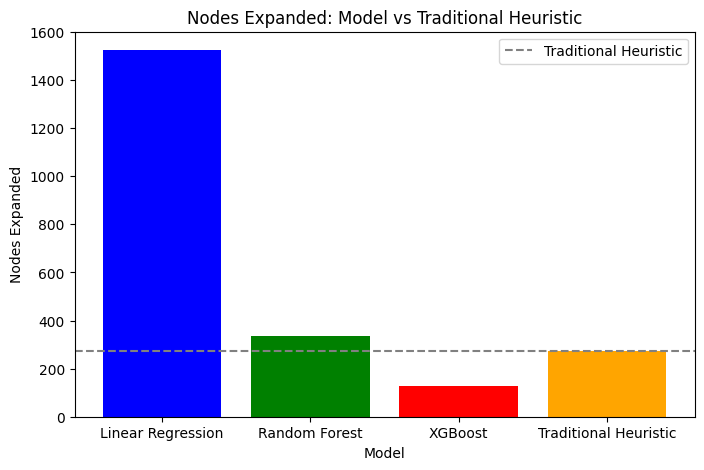

In [ ]:
import matplotlib.pyplot as plt

# Data
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'Traditional Heuristic']
nodes_expanded = [1525, 334, 127, 273]  # From the table

# Visualization
plt.figure(figsize=(8, 5))
plt.bar(models, nodes_expanded, color=['blue', 'green', 'red', 'orange'])

# Titles and labels
plt.title('Nodes Expanded: Model vs Traditional Heuristic')
plt.xlabel('Model')
plt.ylabel('Nodes Expanded')

# Highlight Traditional Heuristic for clarity
plt.axhline(y=273, color='gray', linestyle='--', label='Traditional Heuristic')
plt.legend()

plt.show()



Search time comparison

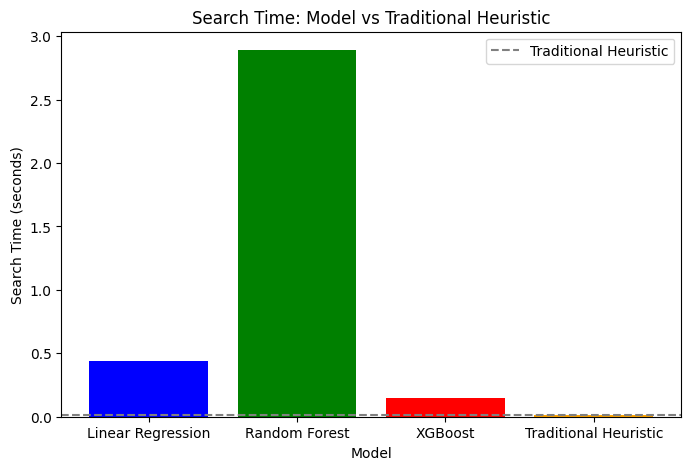

In [ ]:
import matplotlib.pyplot as plt

# Data
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'Traditional Heuristic']
search_time = [0.44, 2.89, 0.15, 0.013]  # Search time in seconds

# Visualization
plt.figure(figsize=(8, 5))
plt.bar(models, search_time, color=['blue', 'green', 'red', 'orange'])

# Titles and labels
plt.title('Search Time: Model vs Traditional Heuristic')
plt.xlabel('Model')
plt.ylabel('Search Time (seconds)')

# Highlight Traditional Heuristic for clarity
plt.axhline(y=0.013, color='gray', linestyle='--', label='Traditional Heuristic')
plt.legend()

plt.show()


Overall Comparison

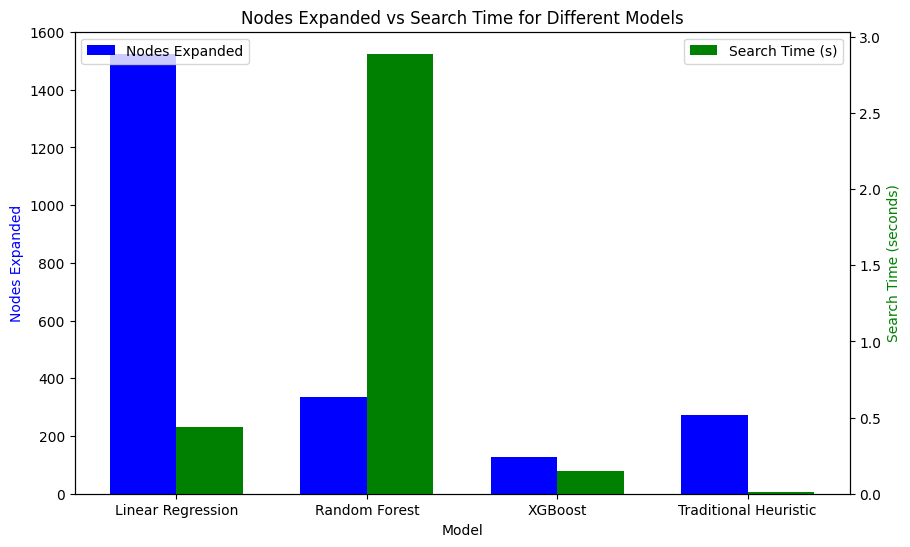

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'Traditional Heuristic']
nodes_expanded = [1525, 334, 127, 273]
search_time = [0.44, 2.89, 0.15, 0.013]

# Create subplots for dual comparison
fig, ax1 = plt.subplots(figsize=(10, 6))

# Set position of bars
bar_width = 0.35
index = np.arange(len(models))

# Plot Nodes Expanded
bar1 = ax1.bar(index, nodes_expanded, bar_width, color='blue', label='Nodes Expanded')

# Create a secondary axis for search time
ax2 = ax1.twinx()
bar2 = ax2.bar(index + bar_width, search_time, bar_width, color='green', label='Search Time (s)')

# Labels and titles
ax1.set_xlabel('Model')
ax1.set_ylabel('Nodes Expanded', color='blue')
ax2.set_ylabel('Search Time (seconds)', color='green')
plt.title('Nodes Expanded vs Search Time for Different Models')

# X-axis labels
plt.xticks(index + bar_width / 2, models)

# Legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()
